In [1]:
import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
#from astropy.visualization import make_lupton_rgb
import cv2 
import matplotlib.gridspec as gridspec


/home/msiudek/myspace/software/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-08 19:27:57.953893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739042878.044921   23729 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739042878.070389   23729 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-08 19:27:58.312280: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-cr

In [121]:
# Create a Grid Layout for Thumbnails
def create_grid_layout(zss_2d, grid_size=(50,50)):
    """
    Adjusts the positions of embeddings into a grid layout while maintaining relative structure.
    """
    x_min, x_max = np.min(zss_2d[:, 0]), np.max(zss_2d[:, 0])
    y_min, y_max = np.min(zss_2d[:, 1]), np.max(zss_2d[:, 1])

    x_scaled = (zss_2d[:, 0] - x_min) / (x_max - x_min) * (grid_size[0] - 1)
    y_scaled = (zss_2d[:, 1] - y_min) / (y_max - y_min) * (grid_size[1] - 1)

    grid_positions = np.stack([x_scaled, y_scaled], axis=-1).astype(int)
    return grid_positions

In [122]:
def transform_latent_space(data_2d, angle_degrees, vertical_flip=False):
    """
    Rotates 2D data clockwise by a given angle in degrees and optionally applies a vertical flip.

    Parameters:
    - data_2d: np.ndarray, shape (n_samples, 2)
        The 2D data to transform.
    - angle_degrees: float
        The angle in degrees to rotate the data.
    - vertical_flip: bool
        Whether to apply a vertical flip (negates the y-coordinate).

    Returns:
    - np.ndarray: Transformed 2D data.
    """
    # Rotation
    theta = np.radians(angle_degrees)  # Convert angle to radians
    rotation_matrix = np.array([[np.cos(theta), np.sin(theta)],
                                 [-np.sin(theta), np.cos(theta)]])  # Clockwise rotation
    rotated_data = np.dot(data_2d, rotation_matrix.T)

    # Vertical flip (negate the y-coordinate)
    if vertical_flip:
        flipped_data = rotated_data * np.array([1, -1])  # Flip y-axis
        return flipped_data

    return rotated_data




In [127]:
def visualize_colored_thumbnails(grid_positions, file_names_vis, file_names_y, file_names_j, file_names_h, \
                      cutout_folder_vis, cutout_folder_y, cutout_folder_j, cutout_folder_h, size=112, figsize=(20, 20)):
    """
    Visualize galaxy embeddings with enhanced colorized thumbnails arranged on a grid.
    
    Parameters:
    - grid_positions: List of tuples indicating grid positions (gx, gy).
    - thumbnails: List of 2D numpy arrays representing thumbnail images.
    - figsize: Figure size for the visualization.
    """
    
 

    def load_and_process_image(file_path, size, q, clip):
        """Helper function to load and process a single FITS file."""
        if os.path.exists(file_path):
            try:
                image_data = fits.getdata(file_path, ext=0)
                if image_data is None or image_data.size == 0:
                    raise ValueError("No valid image data found.")
                
                #image_data = np.flipud(image_data)
                image_data = np.arcsinh(image_data * q)
                if clip < 100:
                    image_data = np.clip(image_data, 0, np.percentile(image_data, clip))
                h, w = image_data.shape
                image_data = image_data[h // 2 - size // 2: h // 2 + size // 2, w // 2 - size // 2: w // 2 + size // 2]
                return image_data 
            except Exception:
                #print(f"Error processing image {file_path}: {e}")
                return np.zeros((size, size))  # Return blank cutout for errors
        else:
            print(f"File not found: {file_path}")
            return np.zeros((size, size))  # Return blank cutout for missing files
        
    #canvas_size = size * 100  # Assuming a fixed canvas layout (100x100 grid with 112x112 pixel thumbnails)
    #canvas = np.ones((canvas_size, canvas_size, 3))  # RGB Canvas for Grid Layout
    canvas_size = size * 50 # Adjust for the new grid size
    canvas = np.ones((canvas_size, canvas_size, 3))  # RGB Canvas for Grid Layout

    
    cutout_images = []
    
    for name_vis, name_y, name_j, name_h in zip(file_names_vis, file_names_y, file_names_j, file_names_h):
        path_y = os.path.join(cutout_folder_y, name_y)
        path_j = os.path.join(cutout_folder_j, name_j)
        path_h = os.path.join(cutout_folder_h, name_h)
        path_vis = os.path.join(cutout_folder_vis, name_vis)
        
        # Load the Y, J, and H band images
        image_y = load_and_process_image(path_y, size, q=1, clip=99.85)
        image_j = load_and_process_image(path_j, size, q=1, clip=99.85)
        image_h = load_and_process_image(path_h, size, q=1, clip=99.85)
        image_vis = load_and_process_image(path_vis, size, q=500, clip=99.85)
        
        if np.all(image_y == 0) and np.all(image_j == 0) and np.all(image_h == 0) and np.all(image_vis == 0):
            invalid_count += 1
            continue        
        try:
            nisp_channel = np.mean([image_h, image_j, image_y], axis=0)
            mean_channel = np.mean([image_vis, nisp_channel], axis=0)
            rgb_image = np.stack([mean_channel, nisp_channel, image_vis], axis=2)
            
            mean_flux = np.mean([image_vis, nisp_channel], axis=0)

            def to_uint8(im, clip_below_zero=True):
                if clip_below_zero:
                    im = np.clip(im, 0, None)
                im = (im + im.min()) / (im.min() + im.max())
                return (255 * im).astype(np.uint8)

            vis_uint8 = to_uint8(image_vis)
            nisp_uint8 = to_uint8(nisp_channel)
            mean_flux_uint8 = to_uint8(mean_flux)

            im = np.stack([nisp_uint8, mean_flux_uint8, vis_uint8], axis=2)
            im = replace_luminosity_channel(im, rgb_channel_for_luminosity=2, desaturate_speckles= False)
            
            cutout_images.append(im)

        except Exception as e:
            print(f"Error combining RGB channels for images {name_y}, {name_j}, {name_h}: {e}")
            invalid_count += 1

    for (gx, gy), thumbnail in zip(grid_positions, cutout_images):
        if thumbnail is None or np.all(thumbnail == 0):  # Skip invalid or blank thumbnails
            continue

        try:          
            # Place the processed thumbnail on the canvas
            x_start, y_start = gx * size, gy * size
            canvas[x_start : x_start + size, y_start : y_start + size] = thumbnail / 255.0  # Normalize to [0, 1] for display


        except Exception as e:
            print(f"Error processing thumbnail at grid position ({gx}, {gy}): {e}")
            continue

    return canvas

In [118]:
def replace_luminosity_channel(rgb_image, rgb_channel_for_luminosity, desaturate_speckles= False):
    lab_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2LAB)
    # Replace L channel
    lab_image[:, :, 0] = rgb_image[:, :, rgb_channel_for_luminosity]
    # Convert back to RGB
    modified_rgb_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)

    if desaturate_speckles:
        modified_rgb_image = desaturate_bright_pixels(modified_rgb_image, 90)
    return modified_rgb_image

# this tends to give "blue speckles" from the blue channel/luminsity background
# desaturate individual pixels brighter than nearby pixels
def desaturate_bright_pixels(rgb_image, threshold):
    hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    # find highly saturated pixels
    saturation = hsv_image[:, :, 1]
    # saturation_nansafe = np.where
    # saturation_smoothed = cv2.medianBlur(saturation, 9)
    # saturation_diff = saturation - saturation_smoothed
    # desaturate highly saturated pixels
    # threshold = np.percentile(saturation, percentile)


    # threshold = threshold  # 0-255
    oversaturated = saturation > threshold
    hsv_image[:, :, 1] = np.clip(saturation, 0, threshold)
    lightness = hsv_image[:, :, 2]
    hsv_image[:, :, 2] = np.where(oversaturated, lightness * 0.5, lightness)

    # desaturation_factor = np.clip(saturation_diff / threshold, 0, 1)
    # hsv_image[:, :, 1] = hsv_image[:, :, 1] * (1 - desaturation_factor)
    # hsv_image[:, :, 2] = saturation_diff
    # Convert back to RGB
    modified_rgb_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    # modified_rgb_image = saturation > threshold

    # bkg = hsv_image[:, :, 2] < (median - std)

    # print(threshold, (saturation.min(), saturation.max()), saturation.mean(), (saturation > threshold).mean())
    # return saturation > 170
    return modified_rgb_image

In [95]:
def show_cutouts_nisp(file_names_vis, file_names_y, file_names_j, file_names_h, \
                      cutout_folder_vis, cutout_folder_y, cutout_folder_j, cutout_folder_h, 
                      size=112):

    def load_and_process_image(file_path, size, q, clip):
        """Helper function to load and process a single FITS file."""
        if os.path.exists(file_path):
            try:
                image_data = fits.getdata(file_path, ext=0)
                if image_data is None or image_data.size == 0:
                    raise ValueError("No valid image data found.")
                
                #image_data = np.flipud(image_data)
                image_data = np.arcsinh(image_data * q)
                if clip < 100:
                    image_data = np.clip(image_data, 0, np.percentile(image_data, clip))

                # Normalize the image
                #image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
                # Extract the central cutout
                h, w = image_data.shape
                image_data = image_data[h // 2 - size // 2: h // 2 + size // 2, w // 2 - size // 2: w // 2 + size // 2]
                # Clip the data to avoid oversaturation
                #interval = PercentileInterval(q)
                #clipped_data = interval(image_data)
                # Apply Asinh scaling to reduce brightness
                #scaled_data = np.arcsinh(clipped_data * stretch)
                return image_data #scaled_data / np.arcsinh(stretch)
            except Exception:
                #print(f"Error processing image {file_path}: {e}")
                return np.zeros((size, size))  # Return blank cutout for errors
        else:
            print(f"File not found: {file_path}")
            return np.zeros((size, size))  # Return blank cutout for missing files

    cutout_images = []
    invalid_count = 0

    for name_vis, name_y, name_j, name_h in zip(file_names_vis, file_names_y, file_names_j, file_names_h):
        path_y = os.path.join(cutout_folder_y, name_y)
        path_j = os.path.join(cutout_folder_j, name_j)
        path_h = os.path.join(cutout_folder_h, name_h)
        path_vis = os.path.join(cutout_folder_vis, name_vis)
        
        # Load the Y, J, and H band images
        image_y = load_and_process_image(path_y, size, q=1, clip=99.85)
        image_j = load_and_process_image(path_j, size, q=1, clip=99.85)
        image_h = load_and_process_image(path_h, size, q=1, clip=99.85)
        image_vis = load_and_process_image(path_vis, size, q=500, clip=99.85)

        if np.all(image_y == 0) and np.all(image_j == 0) and np.all(image_h == 0) and np.all(image_vis == 0):
            invalid_count += 1
            continue

        # Combine into composite
        try:
            
            nisp_channel = np.mean([image_h, image_j, image_y], axis=0)
            mean_channel = np.mean([image_vis, nisp_channel], axis=0)
            rgb_image = np.stack([mean_channel, nisp_channel, image_vis], axis=2)
            
            mean_flux = np.mean([image_vis, nisp_channel], axis=0)

            def to_uint8(im, clip_below_zero=True):
                if clip_below_zero:
                    im = np.clip(im, 0, None)
                im = (im + im.min()) / (im.min() + im.max())
                return (255 * im).astype(np.uint8)


            vis_uint8 = to_uint8(image_vis)
            nisp_uint8 = to_uint8(nisp_channel)
            mean_flux_uint8 = to_uint8(mean_flux)

            im = np.stack([nisp_uint8, mean_flux_uint8, vis_uint8], axis=2)
            im = replace_luminosity_channel(im, rgb_channel_for_luminosity=2, desaturate_speckles= False)
            

            cutout_images.append(im)

        except Exception as e:
            print(f"Error combining RGB channels for images {name_y}, {name_j}, {name_h}: {e}")
            invalid_count += 1

    print(f"Number of invalid cutouts: {invalid_count}")
    return cutout_images


In [92]:
def show_cutouts_vis(file_names_vis, cutout_folder_vis, size=112):

    def load_and_process_image(file_path, size, q, clip):
        """Helper function to load and process a single FITS file."""
        if os.path.exists(file_path):
            try:
                image_data = fits.getdata(file_path, ext=0)
                if image_data is None or image_data.size == 0:
                    raise ValueError("No valid image data found.")
                
                #image_data = np.flipud(image_data)
                image_data = np.arcsinh(image_data * q)
                if clip < 100:
                    image_data = np.clip(image_data, 0, np.percentile(image_data, clip))

                # Normalize the image
                #image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
                # Extract the central cutout
                h, w = image_data.shape
                image_data = image_data[h // 2 - size // 2: h // 2 + size // 2, w // 2 - size // 2: w // 2 + size // 2]
                # Clip the data to avoid oversaturation
                #interval = PercentileInterval(q)
                #clipped_data = interval(image_data)
                # Apply Asinh scaling to reduce brightness
                #scaled_data = np.arcsinh(clipped_data * stretch)
                return image_data #scaled_data / np.arcsinh(stretch)
            except Exception:
                #print(f"Error processing image {file_path}: {e}")
                return np.zeros((size, size))  # Return blank cutout for errors
        else:
            print(f"File not found: {file_path}")
            return np.zeros((size, size))  # Return blank cutout for missing files

    cutout_images = []
    invalid_count = 0

    for name_vis in file_names_vis:
        path_vis = os.path.join(cutout_folder_vis, name_vis)
        
        image_vis = load_and_process_image(path_vis, size, q=100, clip=99.85)

        if np.all(image_vis == 0):
            invalid_count += 1
            continue

        # Combine into composite
        try:            

            def to_uint8(im, clip_below_zero=True):
                if clip_below_zero:
                    im = np.clip(im, 0, None)
                im = (im + im.min()) / (im.min() + im.max())
                return (255 * im).astype(np.uint8)


            vis_uint8 = to_uint8(image_vis)
            
            cutout_images.append(vis_uint8)

        except Exception as e:
            print(f"Error combining RGB channels for images {name_vis}: {e}")
            invalid_count += 1

    print(f"Number of invalid cutouts: {invalid_count}")
    return cutout_images


In [110]:
def visualize_with_zoom(grid_positions, file_names_vis, file_names_y, file_names_j, file_names_h, \
                      cutout_folder_vis, cutout_folder_y, cutout_folder_j, cutout_folder_h, size=112, figsize=(25, 20),
                        edge_left_files_vis=[], edge_left_files_y=[], edge_left_files_j=[], edge_left_files_h=[], \
                        spiral_bottom_files_vis=[], spiral_bottom_files_y=[], spiral_bottom_files_j=[], spiral_bottom_files_h=[], \
                        star_right_files_vis=[], star_right_files_y=[], star_right_files_j=[], star_right_files_h=[], \
                        elliptical_top_files_vis=[], elliptical_top_files_y=[], elliptical_top_files_j=[], elliptical_top_files_h=[],\
                        output_path=None):
    
    """
    Visualize embeddings with thumbnails and prepare space for zoom-in regions around the main panel.
    
    Parameters:
    - grid_positions: List of tuples indicating grid positions (gx, gy).
    - thumbnails: List of 2D numpy arrays representing thumbnail images.
    - size: Size of each thumbnail in the grid.
    - figsize: Size of the entire figure.
    - stretch, Q: Parameters for `make_lupton_rgb` to enhance image coloring.
    - edge_left_files, spiral_bottom_files, star_right_files, elliptical_top_files: 
      Lists of file names for zoom-in regions.
    - cutout_folder: Path to the folder containing FITS images for zoom-ins.
    """
    # Create the main embedding visualization
    canvas = visualize_colored_thumbnails(grid_positions, file_names_vis, file_names_y, file_names_j, file_names_h, \
                      cutout_folder_vis, cutout_folder_y, cutout_folder_j, cutout_folder_h, size=size, figsize=figsize)
                           
    # Set up the gridspec layout
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(3, 3, figure=fig, width_ratios=[1, 2, 1], height_ratios=[1, 2, 1])
    
    # Main central plot
    ax_main = fig.add_subplot(gs[1, 1])
    ax_main.imshow(canvas, origin="lower")
    ax_main.axis("off")
    #ax_main.set_title("Embedding Visualization")

    # Helper function to handle zoom-in panels

    def add_zoom_panel(ax, file_names_vis,file_names_y, file_names_j, file_names_h, position, title):
        if len(file_names_vis) > 0 and len(file_names_y) > 0 and len(file_names_j) > 0 and len(file_names_h) > 0:
            zoom_images = show_cutouts_nisp(file_names_vis,file_names_y, \
                        file_names_j, file_names_h, \
                        cutout_folder_vis, cutout_folder_y, \
                        cutout_folder_j, cutout_folder_h, size=112)
            zoom_grid = np.vstack([np.hstack(zoom_images[i:i+2]) for i in range(0, min(len(zoom_images), 20), 3)])
            #zoom_grid = np.vstack([np.hstack(zoom_images[i:i+10]) for i in range(0, min(len(zoom_images), 20), 10)])
            ax.imshow(zoom_grid)
            ax.axis("off")
            #ax.set_title(title)

    def add_zoom_panel_top(ax, file_names_vis,file_names_y, file_names_j, file_names_h, position, title):
        if len(file_names_vis) > 0 and len(file_names_y) > 0 and len(file_names_j) > 0 and len(file_names_h) > 0:
            zoom_images = show_cutouts_nisp(file_names_vis,file_names_y, \
                        file_names_j, file_names_h, \
                        cutout_folder_vis, cutout_folder_y, \
                        cutout_folder_j, cutout_folder_h , size=112)
            #zoom_grid = np.hstack([np.hstack(zoom_images[i:i+2]) for i in range(0, len(zoom_images), 3)])
            zoom_grid = np.vstack([np.hstack(zoom_images[i:i+10]) for i in range(0, min(len(zoom_images), 20), 10)])
            ax.imshow(zoom_grid)
            ax.axis("off")
            #ax.set_title(title)
            
    # Left zoom-in panel (edge-on galaxies)
    ax_left = fig.add_subplot(gs[1, 0])
    add_zoom_panel(ax_left, edge_left_files_vis, edge_left_files_y, edge_left_files_j, edge_left_files_h, "left", "Edge-On Galaxies")

    # Bottom zoom-in panel (spiral galaxies)
    ax_bottom = fig.add_subplot(gs[2, 1])
    add_zoom_panel_top(ax_bottom, spiral_bottom_files_vis, spiral_bottom_files_y, spiral_bottom_files_j, spiral_bottom_files_h, "bottom", "Spiral Galaxies")

    # Right zoom-in panel (stars)
    ax_right = fig.add_subplot(gs[1, 2])
    add_zoom_panel(ax_right, star_right_files_vis, star_right_files_y, star_right_files_j, star_right_files_h, "right", "Stars")

    # Top zoom-in panel (elliptical galaxies)
    ax_top = fig.add_subplot(gs[0, 1])
    add_zoom_panel_top(ax_top, elliptical_top_files_vis, elliptical_top_files_y, elliptical_top_files_j, elliptical_top_files_h, "top", "Elliptical Galaxies")
    
    # Adjust layout and display the figure
    plt.tight_layout()
        # Save or show
    if output_path:
        plt.savefig(output_path)
    else:
        plt.show()
    plt.close()


In [64]:
# Paths and file names VIS+NIPS
catalog_path_nisp = "UMAP_VIS_train2.fits"  
vis_folder_path = '../../Q1_data/VIS/' 
nisp_h_folder_path = '../../Q1_data/NIR-H/' 
nisp_j_folder_path = '../../Q1_data/NIR-J/' 
nisp_y_folder_path = '../../Q1_data/NIR-Y/' 

# Load the FITS catalog
with fits.open(catalog_path_nisp) as hdul:
    catalog = hdul[1].data

num_objects = len(catalog)

sample_size = 10000

random_indices = np.random.choice(num_objects, size=sample_size, replace=False)
catalog_data_nisp = catalog[random_indices]

# Extract catalog properties
object_ids_nisp = catalog_data_nisp['object_id']
catalog_file_names_nisp_h = catalog_data_nisp['name_nir_h']
catalog_file_names_nisp_j = catalog_data_nisp['name_nir_j']
catalog_file_names_nisp_y = catalog_data_nisp['name_nir_y']
catalog_file_names_vis = catalog_data_nisp['name']

umap1_nisp = catalog_data_nisp['UMAP1']
umap2_nisp = catalog_data_nisp['UMAP2']
spiral_arms_nisp = catalog_data_nisp['has_spiral_arms_yes']
smooth_nisp = catalog_data_nisp['smooth_or_featured_smooth']
class_nisp = catalog_data_nisp['classification.Type']
edge_on_nisp = catalog_data_nisp['disk_edge_on_yes'] 
det_flag_nisp = catalog_data_nisp['det_quality_flag'] 

# Combine UMAP coordinates into a 2D array
zss_nisp = np.column_stack((umap1_nisp, umap2_nisp))

# Map catalog file names to indices
file_name_to_index_nisp_h = {name: idx for idx, name in enumerate(catalog_file_names_nisp_h)}
file_name_to_index_nisp_j = {name: idx for idx, name in enumerate(catalog_file_names_nisp_j)}
file_name_to_index_nisp_y = {name: idx for idx, name in enumerate(catalog_file_names_nisp_y)}
file_name_to_index_vis = {name: idx for idx, name in enumerate(catalog_file_names_vis)}

In [69]:
print("UMAP for VIS+NISP completed.")
print("UMAP coordinates shape:", zss_nisp.shape)

UMAP for VIS+NISP completed.
Thumbnails H shape: (10000, 112, 112)
Thumbnails Y shape: (10000, 112, 112)
Thumbnails J shape: (10000, 112, 112)
Thumbnails VIS shape: (10000, 112, 112)
UMAP coordinates shape: (10000, 2)


In [70]:
# adding the left panel for edge-on
edge_on =  (umap2_nisp > 5) & (umap2_nisp < 7.5) & (umap1_nisp < -1.7) & (edge_on_nisp > 50) & \
                 (catalog_file_names_nisp_y != '') & (catalog_file_names_nisp_j != '') & \
                (catalog_file_names_nisp_h != '') & (catalog_file_names_vis != '')

edge_left_vis = np.array(catalog_file_names_vis)[edge_on]
edge_left_h = np.array(catalog_file_names_nisp_h)[edge_on]
edge_left_j = np.array(catalog_file_names_nisp_j)[edge_on]
edge_left_y = np.array(catalog_file_names_nisp_y)[edge_on]


Number of invalid cutouts: 0


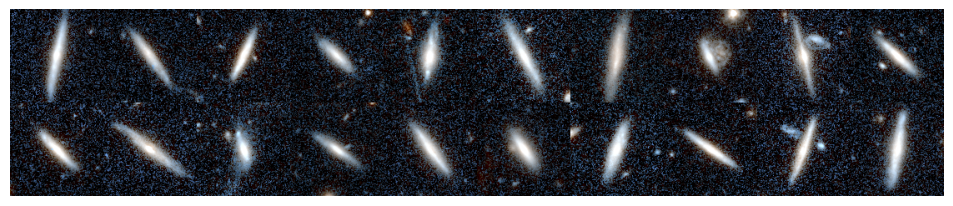

In [109]:
images_nisp = show_cutouts_nisp(
    file_names_vis=edge_left_vis,
    file_names_y=edge_left_y,
    file_names_j=edge_left_j,
    file_names_h=edge_left_h,
    cutout_folder_vis=vis_folder_path,
    cutout_folder_y=nisp_y_folder_path,
    cutout_folder_j=nisp_j_folder_path,
    cutout_folder_h=nisp_h_folder_path,
    size=112
)
grid_nisp = np.vstack([np.hstack(images_nisp[i:i+10]) for i in range(0, min(len(images_nisp), 20), 10)])
#grid_nisp = np.vstack([np.hstack(images_nisp[i:i+2]) for i in range(0, min(len(images_nisp), 20), 3)])

# Display the grid
plt.figure(figsize=(10, 7))
plt.imshow(grid_nisp)
plt.tight_layout()

plt.axis('off')
plt.show()

In [71]:
# adding the spiral bottom panel
spiral_zoom =  (umap2_nisp > 0) & (umap2_nisp < 2.5) & (umap1_nisp > -1) & (umap1_nisp < 1) & (spiral_arms_nisp > 90) & \
                 (catalog_file_names_nisp_y != '') & (catalog_file_names_nisp_j != '') & \
                (catalog_file_names_nisp_h != '') & (catalog_file_names_vis != '')

spiral_bottom_vis = np.array(catalog_file_names_vis)[spiral_zoom]
spiral_bottom_h = np.array(catalog_file_names_nisp_h)[spiral_zoom]
spiral_bottom_j = np.array(catalog_file_names_nisp_j)[spiral_zoom]
spiral_bottom_y = np.array(catalog_file_names_nisp_y)[spiral_zoom]


In [72]:
# adding the star right panel
star_zoom = (umap2_nisp > 5) & (umap2_nisp < 10) &  (umap1_nisp > 5) & (class_nisp == 'star') & \
                 (catalog_file_names_nisp_y != '') & (catalog_file_names_nisp_j != '') & \
                (catalog_file_names_nisp_h != '') & (catalog_file_names_vis != '')

star_right_vis = np.array(catalog_file_names_vis)[star_zoom]
star_right_h = np.array(catalog_file_names_nisp_h)[star_zoom]
star_right_j = np.array(catalog_file_names_nisp_j)[star_zoom]
star_right_y = np.array(catalog_file_names_nisp_y)[star_zoom]

In [73]:
# adding the elliptical top panel
elliptical_zoom = (umap2_nisp > 2.5) & (umap2_nisp < 7.5) & (umap1_nisp > 2.3) & (umap1_nisp < 5)  & (smooth_nisp > 50) & \
                 (catalog_file_names_nisp_y != '') & (catalog_file_names_nisp_j != '') & \
                (catalog_file_names_nisp_h != '') & (catalog_file_names_vis != '')

elliptical_top_vis = np.array(catalog_file_names_vis)[elliptical_zoom]
elliptical_top_h = np.array(catalog_file_names_nisp_h)[elliptical_zoom]
elliptical_top_j = np.array(catalog_file_names_nisp_j)[elliptical_zoom]
elliptical_top_y = np.array(catalog_file_names_nisp_y)[elliptical_zoom]


In [119]:
# Rotate the latent space by a desired angle (e.g., 45 degrees clockwise)

zss_vis_2d_transformed = transform_latent_space(zss_nisp, angle_degrees=90, vertical_flip=True)



In [129]:
visualize_with_zoom(
    grid_positions=create_grid_layout(zss_vis_2d_transformed),
    file_names_vis=catalog_file_names_vis,
    file_names_y=file_name_to_index_nisp_y, 
    file_names_j=file_name_to_index_nisp_j, 
    file_names_h=file_name_to_index_nisp_h,
    size=60, figsize=(25, 20),
    edge_left_files_vis=edge_left_vis,
    edge_left_files_y=edge_left_y,
    edge_left_files_j=edge_left_j,
    edge_left_files_h=edge_left_h,    
    spiral_bottom_files_vis=spiral_bottom_vis,
    spiral_bottom_files_y=spiral_bottom_y,
    spiral_bottom_files_j=spiral_bottom_j,
    spiral_bottom_files_h=spiral_bottom_h,
    star_right_files_vis=star_right_vis,
    star_right_files_y=star_right_y,
    star_right_files_j=star_right_j,
    star_right_files_h=star_right_h,
    elliptical_top_files_vis=elliptical_top_vis,
    elliptical_top_files_y=elliptical_top_y,
    elliptical_top_files_j=elliptical_top_j,
    elliptical_top_files_h=elliptical_top_h,
    cutout_folder_vis=vis_folder_path,
    cutout_folder_y=nisp_y_folder_path,
    cutout_folder_j=nisp_j_folder_path,
    cutout_folder_h=nisp_h_folder_path,
    output_path="cutout_VISembedding_NISP_VIS.png"
)

/tmp/ipykernel_38159/2689556839.py:69: RuntimeWarning: invalid value encountered in divide
  im = (im + im.min()) / (im.min() + im.max())
/tmp/ipykernel_38159/2689556839.py:70: RuntimeWarning: invalid value encountered in cast
  return (255 * im).astype(np.uint8)


the files are ok
Number of invalid cutouts: 0
Number of invalid cutouts: 0
the files are ok
Number of invalid cutouts: 0
Number of invalid cutouts: 0
